In [2]:
!pip install datasets evaluate transformers[sentencepiece]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
#下载关于药品评论的原始数据并解压缩
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
!unzip drugsCom_raw.zip

In [ ]:
from datasets import load_dataset
#指定训练集和测试集的路径
data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
drug_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")  #这里设置\t可以确保正确的按照制表符分割加载tsv文件数据，而不是按照默认的csv文件按逗号理解数据


In [ ]:
#使用seed确保打乱的顺序是可重复的，若运行同样的代码，每次打乱的结果会一致

drug_sample = drug_dataset["train"].shuffle(seed=42).select(range(1000))#选择第0行到第999行
#Print first 3 examples of the dataset
drug_sample[:3]

我们需要处理一下数据集，有以下三个需要解决的问题：

Unnamed: 0 列看起来很像每位患者的匿名化 ID。

condition 列包含大小写混合的标签。

reviews 的长度不一，且包含混杂的 Python 换行符（\r\n）以及 HTML 字符代码（如 '）。

为验证Unnamed:0列是否是患者ID的假设，可用Dataset.unique()检查该列的数量是否与每个数据集行数相匹配。若匹配，则说明该列真的是每位患者的唯一标识符。

In [ ]:
#解决问题一：Unnamed: 0 列看起来很像每位患者的匿名化 ID。
#Dataset.unique()用于返回数据集中某一列的所有唯一值
for split in drug_dataset.keys(): #drug_dataset.keys()返回的是数据集的所有拆分名，如["train", "test"]
  assert len(drug_dataset[split]) == len(drug_dataset[split].unique("Unnamed: 0"))
#assert用于检查某些条件是否成立。若条件为True,程序继续执行；反之则抛出AssertionError异常


In [ ]:
#上面顺利执行，说明Unnamed:0列就是患者的唯一标识符
#现在来把这列重命名为patient_id，便于我们理解
drug_dataset = drug_dataset.rename_column(
    original_column_name="Unnamed: 0", new_column_name="patient_id"
)

In [ ]:
drug_dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53766
    })
})

In [ ]:
#解决问题二：condition列包含大小写混合的标签。

def lowercase_condition(example):
  return {"condition": example["condition"].lower()}

drug_dataset.map(lowercase_condition)

Map:   0%|          | 0/161297 [00:00<?, ? examples/s]

AttributeError: 'NoneType' object has no attribute 'lower'

从报错中我们可以推断，condition列中的某些条目式None，which不能被转为小写。

所以让我们使用Data.filter()来删除这些行。

在继续清理数据集之前，先介绍一下匿名函数/lambda函数：

In [ ]:
# lambda <arguments> : <expression>
#例子1
(lambda x: x * x)(3)

9

In [ ]:
#例子2
(lambda base, height: 0.5 * base * height)(4, 8)

16.0

lambda函数适用于定义小型、一次性的函数

In [ ]:
#现在继续进行空行的删除
drug_dataset = drug_dataset.filter(lambda x: x["condition"] is not None)

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53766 [00:00<?, ? examples/s]

In [ ]:
#继续解决第二个问题：condition列包含大小写混合的标签。
drug_dataset = drug_dataset.map(lowercase_condition)


Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

In [ ]:
#check that lowercaing worked
drug_dataset["train"]["condition"][:3]

['left ventricular dysfunction', 'adhd', 'birth control']

In [ ]:
#解决问题三：reviews的长度不一，且包含混杂的Python换行符（\r\n）以及HTML字符代码（如'）。

#计算评论的长度
def compute_review_length(example):
  return {"review_length": len(example["review"].split())}

In [ ]:
drug_dataset = drug_dataset.map(compute_review_length)
#Inspecct the first training example
drug_dataset["train"][0]

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

{'patient_id': 206461,
 'drugName': 'Valsartan',
 'condition': 'left ventricular dysfunction',
 'review': '"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"',
 'rating': 9.0,
 'date': 'May 20, 2012',
 'usefulCount': 27,
 'review_length': 17}

In [ ]:
#对drug_dataset按review_length进行排序并提取升序排序后的前三条数据
drug_dataset["train"].sort("review_length")[:3]

{'patient_id': [111469, 13653, 53602],
 'drugName': ['Ledipasvir / sofosbuvir',
  'Amphetamine / dextroamphetamine',
  'Alesse'],
 'condition': ['hepatitis c', 'adhd', 'birth control'],
 'review': ['"Headache"', '"Great"', '"Awesome"'],
 'rating': [10.0, 10.0, 10.0],
 'date': ['February 3, 2015', 'October 20, 2009', 'November 23, 2015'],
 'usefulCount': [41, 3, 0],
 'review_length': [1, 1, 1]}

In [ ]:
# 只保留review_length大于30的记录，因为过短的记录很可能是没有意义的
drug_dataset = drug_dataset.filter(lambda x: x["review_length"] > 30)
print(drug_dataset.num_rows)

Filter:   0%|          | 0/160398 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53471 [00:00<?, ? examples/s]

{'train': 138514, 'test': 46108}


我们可以看到，这一步移除了15%的reviews

In [ ]:
#unescape会将html实体转换回普通字符，我们先来看个例子
import html

text = "I&#039;m a transformer called BERT"
html.unescape(text)

"I'm a transformer called BERT"

In [ ]:
#现在来正式解决第三个问题
drug_dataset = drug_dataset.map(lambda x: {"review": html.unescape(x["review"])})

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

In [ ]:
#上面一行代码直接接吗整个字符串，适用于字符串
#下面这行代码逐个解码列表中的每条评论，适用于列表；批量处理，提高效率
new_drug_dataset = drug_dataset.map(
    lambda x: {"review": [html.unescape(o) for o in x["review"]]}, batched=True
)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

运行上面这行代码比不使用batch的要快很多。

使用batched=True的Dataset.map()对于“快速分词器（fast tokenizer）”至关重要，它可以对大文本列表进行分词。

例如，要使用fast tokenizer 对所有药物评论进行tokenize，我们可以使用以下函数：

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
  return tokenizer(examples["review"], truncation=True)

In [ ]:
#默认情况下，AutoTokenizer.from_pretrained()会自动选择fast tokenizer版本
#也可以用过设置use_fast=True显式指定，强制使用fast tokenizer
print(type(tokenizer))

<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


可以使用%time来计算该单元格运行的时间

In [ ]:
%time tokenized_dataset = drug_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

CPU times: user 2min 2s, sys: 1.38 s, total: 2min 3s
Wall time: 1min 57s


In [ ]:
#现在来看一下slow tokenizer有多慢
slow_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=False)

def slow_tokenize_function(examples):
  return slow_tokenizer(examples["review"], truncation=True)

In [ ]:
#num_proc=8表示使用8个进程来并行化处理数据集，加快训练速度
%time tokenized_dataset = drug_dataset.map(slow_tokenize_function, batched=True, num_proc=8)

Map (num_proc=8):   0%|          | 0/138514 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/46108 [00:00<?, ? examples/s]

CPU times: user 7.26 s, sys: 935 ms, total: 8.2 s
Wall time: 7min 43s


下面是hugging face官网做的一些小实验结果：
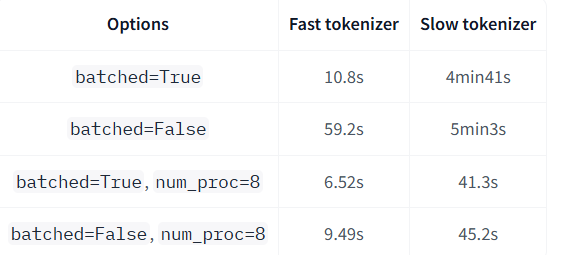

In [ ]:
def tokenize_and_split(examples):
  return tokenizer(
      examples["review"],
      truncation=True,
      max_length=128,
      return_overflowing_tokens=True
#上行的作用是若一个长评论超过max_length,这个参数会返回这些溢出的tokens，而不是仅仅截断后的部分
  )

In [ ]:
#我们来试验一下上面这个函数的效果
result = tokenize_and_split(drug_dataset["train"][0])
[len(inp) for inp in result["input_ids"]]

[128, 49]

So,我们可以得知训练集的第一条数据变成了两个特征，因为它的token数量超过了128。于是，我们得到了两条特征：第一条128，第二条49

In [ ]:
#现在我们开始对整个数据集进行tokenize and split
tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

ArrowInvalid: Column 8 named input_ids expected length 1000 but got length 1463

错误的原因在于input_ids有1000个元素，但是通过map中retun_overflowing_tokens的操作后，每个review可能被拆成了多个片段，这列的长度就变成了1463。

由于原始数据集和新的tokenized数据集长度不一致，Dataset就无法处理这种情况（原因主要与数据集的内部结构和处理方式有关），从而抛出错误。

有两种解决办法：1.移除原数据集的列 2.确保返回的列大小匹配

In [ ]:
#方法一：使用remove_columns移除原数据集的列
#drug_dataset["train"].column_names返回数据集 drug_dataset["train"]中所有列的名称。
#也就是说，所有的列都会被移除。
#这样的结果是得到一个只包含分词结果的新数据集，且不包含任何原始的、未处理的数据

tokenized_dataset = drug_dataset.map(
    tokenize_and_split, batched=True, remove_columns=drug_dataset["train"].column_names
)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

In [ ]:
#看看tokenize and split后与原数据集的不同
len(tokenized_dataset["train"]), len(drug_dataset["train"])

(206772, 138514)

In [1]:
#方法二：确保返回的列大小匹配

#tokenize_and_split用于对输入的examples进行分词，并处理超长文本的情况（即分析后序列长度
#超过了max_length）。同时，它确保了其他字段（如label）与分词后的结果保持对齐。
def tokenize_and_split(examples):
  result = tokenizer(
      examples["review"],
      truncation=True,
      max_length=128,
      return_overflowing_tokens=True
  )
  sample_map = result.pop("overflowing_to_sample_mapping")
  for key,value in examples.items():
    result[key] = [value[i] for i in sample_map]
  return result

**sample_map:**会返回一个列表，表示每个分片对应于原始输入文本中的哪一条。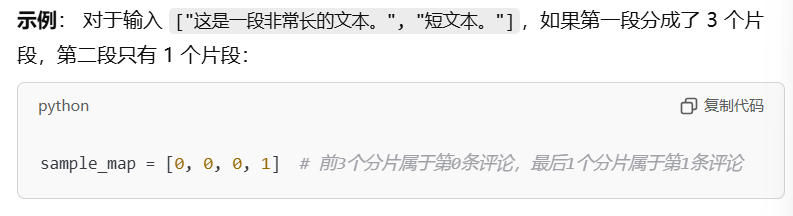

然后还需对齐其他字段（如：label）。通过for循环遍历examples的其他字段，根据sample_map映射调整它们的值，每个字段的值会被复制或重复，确保与分片后的结果对齐。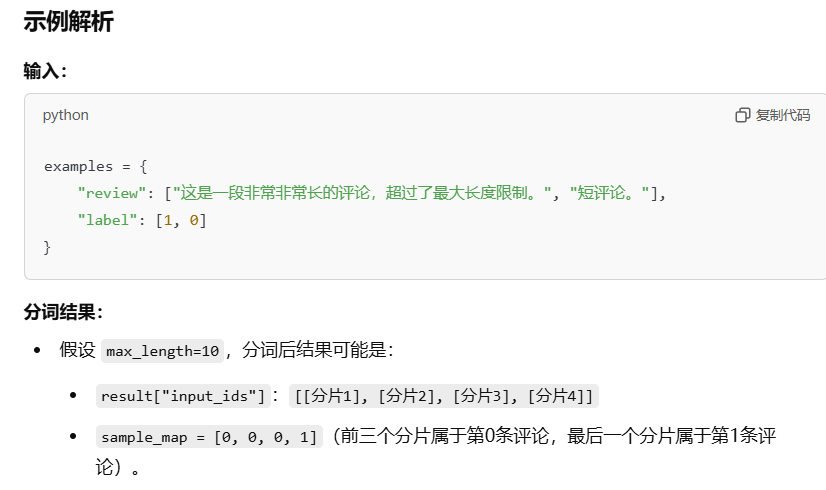

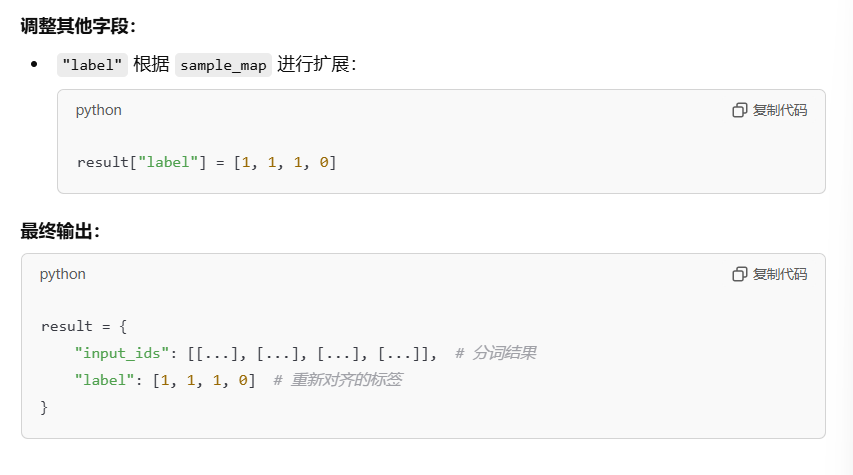

输出是一个字典result，包含以下内容：

1.分词后的结果（包括可能被分割的多个片段）。
2.
重新对齐的其他字段（如 "label"）。

In [ ]:
tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)
tokenized_dataset

In [ ]:
#Dataset中的数据是以字典的形式储存的，pandas是以dataframe格式存储的
#Datasets很方便实现各种第三方库之间的转换
drug_dataset.set_format("pandas")

In [ ]:
drug_dataset["train"][:3]

In [ ]:
#提取train分区的所有数据
train_df = drug_dataset["train"][:]

In [ ]:
#现在我们可以使用所有的pandas功能，例如，我们可以计算condition中的类别频次分布
frequencies = (
    train_df["condition"]
    .value_counts() #计算每个唯一值在该列中出现的次数
    .to_frame() #将结果从pandas series转换为一个dataframe
    .reset_index() #将索引重置为普通列，同时分一个新的默认数值索引
    .rename(columns={"index": "condition", "condition": "frequency"}) #将dataframe的列重新命名：index改为condition,condition改为frequency
)
frequencies.head() #返回Dataframe前5行，用于快速查看数据

In [ ]:
#当我们完成Pandas分析，我们可以使用Dataset.from_pandas函数创建一个新的Dataset对象
from datasets import Dataset

freq_dataset = Dataset.from_pandas(frequencies)
freq_dataset

#将数据集的格式重置为默认格式
drug_dataset.reset_format()

creating a vaidation set

In [ ]:
#80% 的数据将作为新的训练集，剩下 20% 作为验证集
drug_dataset_clean = drug_dataset["train"].train_test_split(train_size=0.8,seed=42)
#rename the default "test" split to "validation"
drug_dataset_clean["validation"] = drug_dataset_clean.pop("test")
#add "test" set from origiinal datseet to our "DatasetDict"
drug_dataset_clean["test"] = drug_dataset["test"]
drug_dataset_clean

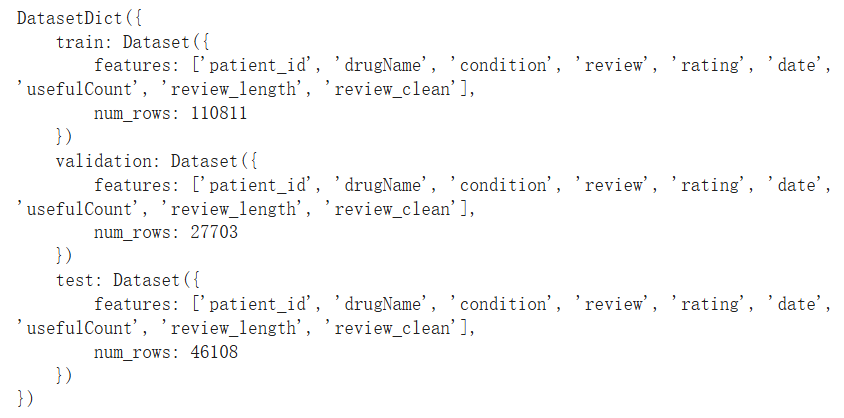

In [ ]:
#将数据集对象drug_dataset_clean保存到本地磁盘，确保数据可以跨会话或跨环境使用
drug_dataset_clean.save_to_disk("drug-reviews") #本地创建一个名为drug-reviews的目录，其中包含数据集的所有内容

#从磁盘重新加载数据集
from datasets import load_from_disk

drug_dataset_reloaded = load_from_disk("drug-reviews") #从本地磁盘的目录drug-reviews中加载数据集
drug_dataset_reloaded

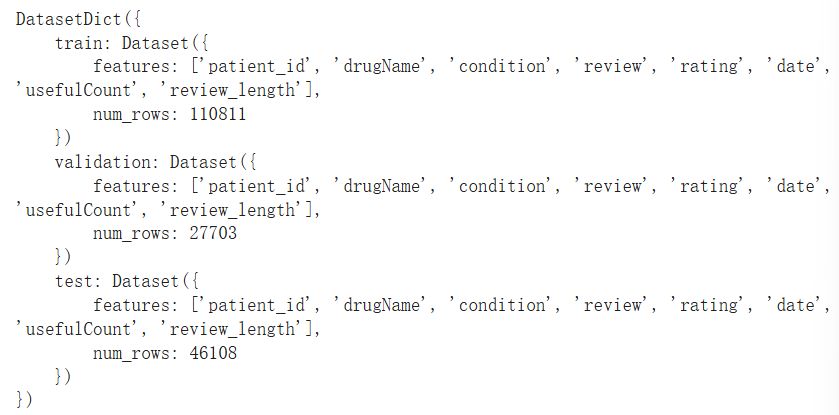

三种储存数据集的方法：

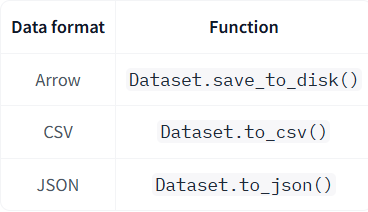

对于CSV和JSON格式，我们必须把每一个split（即分区名称，如train,validation,test）储存为单独的文件。我们可以通过遍历DatasetDict对象中的键值对来实现。

运行代码后，会在当前目录生成三个文件（假设drug_dataset_dlean包含三个分区）：drug-reviews-train.json1, drug-reviews-validation.json1, drug-reviews-test.json1

In [ ]:
for split, dataset in drug_dataset_clean.items():
  dataset.to_json(f"drug-reviews-{split}.json1")

In [ ]:
#Linux命令，查看drug-reviews-train.json1的第一行内容
!head -n 1 drug-reviews-train.json1

In [ ]:
#从指定的JSON Lines文件加载数据集，并按照文件的名称分区为train,validation,test
data_files = {
    "train": "drug-reviews-train.jsonl",
    "validation": "drug-reviews-validation.jsonl",
    "test": "drug-reviews-test.jsonl",
}

drug_dataset_reloaded = load_dataset("json", data_files=data_files)